https://www.quora.com/What’s-the-difference-between-“dropna”-and-“fillna”-in-a-Python-pandas-data-frame

#YouTube Data Extraction and Analysis

In [ ]:
import os

from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow

# The CLIENT_SECRETS_FILE variable specifies the name of a file that contains
# the OAuth 2.0 information for this application, including its client_id and
# client_secret.
CLIENT_SECRETS_FILE = "client_secret.json" #This is the name of your JSON file

# This OAuth 2.0 access scope allows for full read/write access to the
# authenticated user's account and requires requests to use an SSL connection.
SCOPES = ['https://www.googleapis.com/auth/youtube.force-ssl']
API_SERVICE_NAME = 'youtube'
API_VERSION = 'v3'

def get_authenticated_service():
  flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
  credentials = flow.run_console()
  return build(API_SERVICE_NAME, API_VERSION, credentials = credentials)

os.environ['OAUTHLIB_INSECURE_TRANSPORT'] = '1'
service = get_authenticated_service()

# Search Query Initialisation

In [ ]:

query = input("Enter the Query or Topic which you are searching for :")

Enter the Query or Topic which you are searching for :'Stock and Trading'


In [ ]:


query_results = service.search().list(
        part = 'snippet',
        q = query,
        order = 'relevance', # You can consider using viewCount
        maxResults = 50,
        type = 'video', # Channels might appear in search results
        relevanceLanguage = 'en',
        safeSearch = 'moderate',
        ).execute()

In [ ]:
tags = []
commentCount = []
viewsCount = []
categoryId = []
dislikeCount = []

for search_result in query_results.get("items", []):
  if search_result["id"]["kind"] == "youtube#video":
    response = youtube.videos().list(
        part='statistics, snippet',
        id=search_result['id']['videoId']).execute()
    viewsCount.append(response['items'][0]['statistics']['viewCount'])
    categoryId.append(response['items'][0]['snippet']['categoryId'])
    dislikeCount.append(response['items'][0]['statistics']['dislikeCount'])
    
  if('commentCount' in response['items'][0]['statistics'].keys()):
      commentCount.append(response['items'][0]['statistics']['commentCount'])
  else:
      commentCount.append([])  
  if 'tags' in response['items'][0]['snippet'].keys():
      tags.append(response['items'][0]['snippet']['tags'])
  else:
      tags.append([])

# ===============================================
# Get Video IDs
# ===============================================

In [ ]:

channel_id =[]
video_id = []
channel = []
video_title = []
video_desc = [] 
publish = []
for item in query_results['items']:
    channel_id.append(item['snippet']['channelId'])
    video_id.append(item['id']['videoId'])
    channel.append(item['snippet']['channelTitle'])
    video_title.append(item['snippet']['title'])
    publish.append(item['snippet']['publishedAt'])
    video_desc.append(item['snippet']['description'])

# ===========================================
# Get Comments of Top Videos
# ===========================================

In [ ]:

tags_pop=[]
commentCount_pop = []
viewsCount_pop = []
categoryId_pop = []
dislikeCount_pop = []


channel_id_pop = []
video_id_pop = []
channel_pop = []
video_title_pop = []
video_desc_pop = []
comments_pop = []
comment_id_pop = []
reply_count_pop = []
like_count_pop = []
publish_pop = []
from tqdm import tqdm
for i, video in enumerate(tqdm(video_id, ncols = 100)):
    response = service.commentThreads().list(
                    part = 'snippet',
                    videoId = video,
                    maxResults = 100, # Only take top 100 comments...
                    order = 'relevance', #... ranked on relevance
                    textFormat = 'plainText',
                    ).execute()
    
    comments_temp = []
    comment_id_temp = []
    reply_count_temp = []
    like_count_temp = []
    for item in response['items']:
        comments_temp.append(item['snippet']['topLevelComment']['snippet']['textDisplay'])
        comment_id_temp.append(item['snippet']['topLevelComment']['id'])
        reply_count_temp.append(item['snippet']['totalReplyCount'])
        like_count_temp.append(item['snippet']['topLevelComment']['snippet']['likeCount'])
    comments_pop.extend(comments_temp)
    comment_id_pop.extend(comment_id_temp)
    reply_count_pop.extend(reply_count_temp)
    like_count_pop.extend(like_count_temp)
    
    viewsCount_pop.extend([viewsCount[i]]*len(comments_temp))
    categoryId_pop.extend([categoryId[i]]*len(comments_temp))
    dislikeCount_pop.extend([dislikeCount[i]]*len(comments_temp))
    commentCount_pop.extend([commentCount[i]]*len(comments_temp))
    publish_pop.extend([publish[i]]*len(comments_temp))
    channel_id_pop.extend([channel_id[i]]*len(comments_temp))
    tags_pop.extend([tags[i]]*len(comments_temp))
    video_id_pop.extend([video_id[i]]*len(comments_temp))
    channel_pop.extend([channel[i]]*len(comments_temp))
    video_title_pop.extend([video_title[i]]*len(comments_temp))
    video_desc_pop.extend([video_desc[i]]*len(comments_temp))
    
query_pop = [query] * len(video_id_pop)
  
  
  


100%|███████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.63it/s]


#Create DataFrame

In [ ]:
# =============================================================================
# Populate to Dataframe
# =============================================================================
import pandas as pd

output_dict = {
        'Query': query_pop,
        'Tags' : tags_pop,
        'Channel_Name': channel_pop,
        'Channel_Id' :channel_id_pop ,
        'Video ID': video_id_pop,
        'Video_Title': video_title_pop,
        'Publish_Date&Time' : publish_pop,
        'Video_Description': video_desc_pop,
         'No_of_Views': viewsCount_pop,
          'Category_Id': categoryId_pop,
        'No_of_Comments':commentCount_pop,
        'Comment ID': comment_id_pop,
        'Comments': comments_pop,
        'No_of_Replies': reply_count_pop,
        'No_of_Likes': like_count_pop,
         'No_of_Dislikes':dislikeCount_pop,
        }

df = pd.DataFrame(output_dict, columns = output_dict.keys())
print(df.shape)
df.head()

(3930, 16)


,Query,Tags,Channel_Name,Channel_Id,Video ID,Video_Title,Publish_Date&Time,Video_Description,No_of_Views,Category_Id,No_of_Comments,Comment ID,Comments,No_of_Replies,No_of_Likes,No_of_Dislikes
0,Stock and Trading,"[stock trading, the only day trading tutorial ...",Zed Monopoly,UC8xA7gUauoxf0HTfcdiHCOQ,RpHONKLoAsI,The ONLY Stock Trading Video You Will EVER Nee...,2019-07-03T16:37:40.000Z,If you want to trade stocks without the ugly c...,15851,27,99,Ugz1OHg9LIDhhiGtjvd4AaABAg,This will go into more details ;) https://www....,6,9,28
1,Stock and Trading,"[stock trading, the only day trading tutorial ...",Zed Monopoly,UC8xA7gUauoxf0HTfcdiHCOQ,RpHONKLoAsI,The ONLY Stock Trading Video You Will EVER Nee...,2019-07-03T16:37:40.000Z,If you want to trade stocks without the ugly c...,15851,27,99,UgwZX9U_bpkIQcQSlqJ4AaABAg,yes Drop live trades at least twice a week or ...,1,18,28
2,Stock and Trading,"[stock trading, the only day trading tutorial ...",Zed Monopoly,UC8xA7gUauoxf0HTfcdiHCOQ,RpHONKLoAsI,The ONLY Stock Trading Video You Will EVER Nee...,2019-07-03T16:37:40.000Z,If you want to trade stocks without the ugly c...,15851,27,99,UgxTlJBQEqqOr7sJeFt4AaABAg,great video mate. just wanna know what broker ...,0,0,28
3,Stock and Trading,"[stock trading, the only day trading tutorial ...",Zed Monopoly,UC8xA7gUauoxf0HTfcdiHCOQ,RpHONKLoAsI,The ONLY Stock Trading Video You Will EVER Nee...,2019-07-03T16:37:40.000Z,If you want to trade stocks without the ugly c...,15851,27,99,Ugxc0SpaHrTKn33Utsx4AaABAg,I’m confused and mystified at the same time. H...,0,4,28
4,Stock and Trading,"[stock trading, the only day trading tutorial ...",Zed Monopoly,UC8xA7gUauoxf0HTfcdiHCOQ,RpHONKLoAsI,The ONLY Stock Trading Video You Will EVER Nee...,2019-07-03T16:37:40.000Z,If you want to trade stocks without the ugly c...,15851,27,99,UgwbBKS-mqanXZeKRT14AaABAg,liuvmonopoly,0,1,28


In [ ]:
df['Video ID'].value_counts()

48-_p3W4iXI    100
BHq8L0TTWxI    100
wJEmvN73quM    100
L8IzQ7q6Xd8    100
slBxM4J3BEA    100
vk8v3hOT5iY    100
4fY-RVB39Dw    100
vVzW0dDrIHc    100
heETqGrDRuQ    100
4zhco2PA-TM    100
cRMp_vHTwEU    100
W04cfpHTPJ4    100
p7HKvqRI_Bo    100
DLmEhZrYdVc    100
2u007Msq1qo    100
Vd4af7bqcXQ    100
VpR1a9OZvsM    100
ofltPl-52y8    100
fhoI0uSqC7o    100
UCDiiGSly3o    100
dcOUwDyRlhg    100
B4KomrS4nN8    100
S0WcD5kl50M    100
1CizTHIM7BQ    100
AJnISPfuOdA    100
5IcvRe8bQhU    100
xHgTAJw7Fvg    100
yObuV0aaGY8    100
XAm0U7qb2fA    100
PbbsNsdwjLM    100
GTtKLeDTCHo    100
j5PYredaIHo     99
7alIQOX_Dxg     91
ogd-om_x-qo     88
lLZ1rlouPYA     78
X1P6CrOePPs     77
8ggJcPqmg-w     76
XqnmopKa74c     71
RpHONKLoAsI     66
oog9tmli998     44
RNdpqlMWUb8     38
KUbeyr87hDM     32
0xDEoQAFFgE     26
0cLIGl6bcCc     19
WBZg-5ao0e4      8
zknpv1B1vuY      6
A5JIjwwFC_I      3
rROvTF-QY40      3
i48Mc20eoZ8      3
rT_ISKjmZgQ      2
Name: Video ID, dtype: int64

In [ ]:
df.columns

Index(['Query', 'Tags', 'Channel_Name', 'Channel_Id', 'Video ID',
       'Video_Title', 'Publish_Date&Time', 'Video_Description', 'No_of_Views',
       'Category_Id', 'No_of_Comments', 'Comment ID', 'Comments',
       'No_of_Replies', 'No_of_Likes', 'No_of_Dislikes'],
      dtype='object')

## Most Relevant & Appearing keywords on Youtube in the field of trading/Stock -ANALYSE

In [ ]:
key_word  = []
for i in range(len(df)):
  key_word += df['Tags'][i]
  
len(key_word)

98810

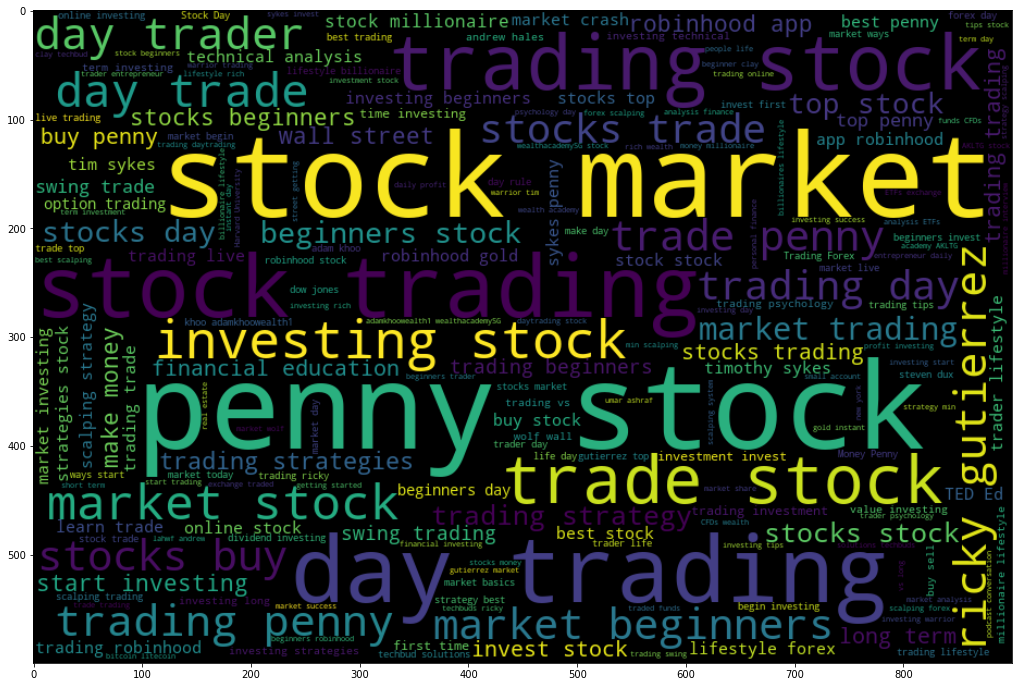

In [ ]:
all_words = ' '.join([tags for tags in key_word])
from wordcloud import WordCloud
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(20, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('on')
plt.show()

In [ ]:
df['No_of_Views'] = df['No_of_Views'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3930 entries, 0 to 3929
Data columns (total 16 columns):
Query                3930 non-null object
Tags                 3930 non-null object
Channel_Name         3930 non-null object
Channel_Id           3930 non-null object
Video ID             3930 non-null object
Video_Title          3930 non-null object
Publish_Date&Time    3930 non-null object
Video_Description    3930 non-null object
No_of_Views          3930 non-null int64
Category_Id          3930 non-null object
No_of_Comments       3930 non-null object
Comment ID           3930 non-null object
Comments             3930 non-null object
No_of_Replies        3930 non-null int64
No_of_Likes          3930 non-null int64
No_of_Dislikes       3930 non-null object
dtypes: int64(3), object(13)
memory usage: 491.3+ KB


#Mostly Watched Videos

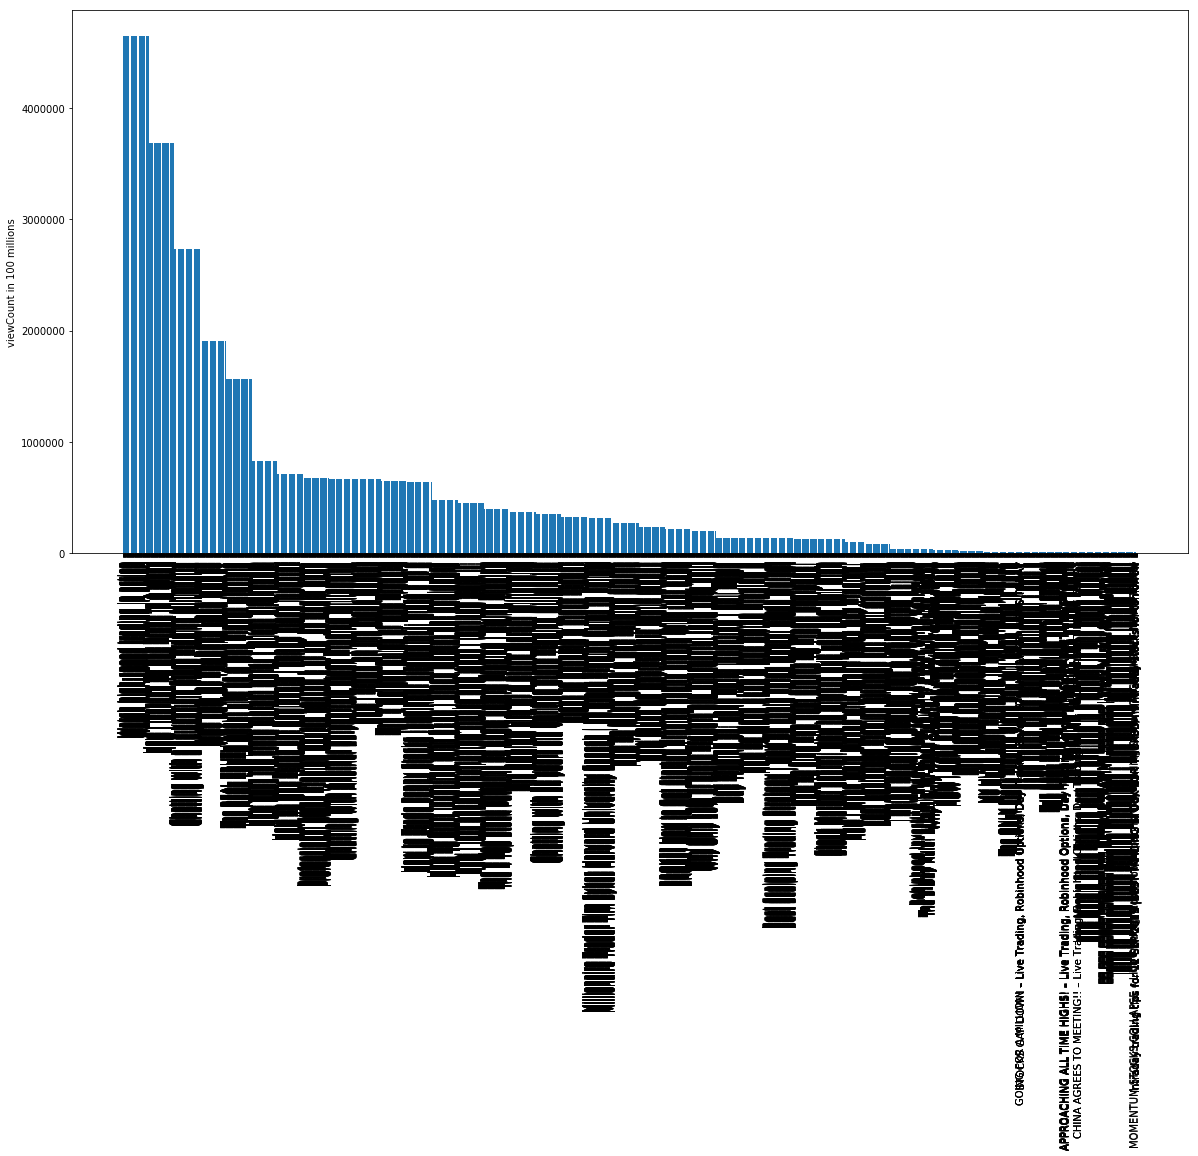

In [ ]:
stock_market = df.copy()
stock_market = stock_market.sort_values(ascending=False,by='No_of_Views')
plt.figure(figsize=(20,10))
plt.bar(range(stock_market.shape[0]),stock_market['No_of_Views'])
plt.xticks(range(stock_market.shape[0]),stock_market['Video_Title'],rotation=90)
plt.ylabel('viewCount in 100 millions')
plt.show()

#This is Not an appropriate Result . 
#NOw move on to the desirable Result/Outcome.
Find the Better Solution

In [ ]:
#df.set_index('Video ID')
dic ={}
df.groupby('Video ID') 
diss = df.groupby('Video ID').groups
for key in diss:
  dic[key] = diss[key][0]

In [ ]:
print(dic)

{'0cLIGl6bcCc': 266, '0xDEoQAFFgE': 3666, '1CizTHIM7BQ': 2585, '2u007Msq1qo': 1539, '48-_p3W4iXI': 3318, '4fY-RVB39Dw': 1839, '4zhco2PA-TM': 485, '5IcvRe8bQhU': 2685, '7alIQOX_Dxg': 3039, '8ggJcPqmg-w': 1163, 'A5JIjwwFC_I': 3036, 'AJnISPfuOdA': 2441, 'B4KomrS4nN8': 66, 'BHq8L0TTWxI': 1439, 'DLmEhZrYdVc': 2785, 'GTtKLeDTCHo': 285, 'KUbeyr87hDM': 3631, 'L8IzQ7q6Xd8': 863, 'PbbsNsdwjLM': 2141, 'RNdpqlMWUb8': 3692, 'RpHONKLoAsI': 0, 'S0WcD5kl50M': 1339, 'UCDiiGSly3o': 963, 'Vd4af7bqcXQ': 1939, 'VpR1a9OZvsM': 3830, 'W04cfpHTPJ4': 1739, 'WBZg-5ao0e4': 3518, 'X1P6CrOePPs': 2956, 'XAm0U7qb2fA': 2341, 'XqnmopKa74c': 2885, 'cRMp_vHTwEU': 2039, 'dcOUwDyRlhg': 763, 'fhoI0uSqC7o': 385, 'heETqGrDRuQ': 1239, 'i48Mc20eoZ8': 3033, 'j5PYredaIHo': 3526, 'lLZ1rlouPYA': 685, 'ofltPl-52y8': 3730, 'ogd-om_x-qo': 3130, 'oog9tmli998': 2541, 'p7HKvqRI_Bo': 585, 'rROvTF-QY40': 3663, 'rT_ISKjmZgQ': 2139, 'slBxM4J3BEA': 166, 'vVzW0dDrIHc': 3218, 'vk8v3hOT5iY': 1639, 'wJEmvN73quM': 2241, 'xHgTAJw7Fvg': 1063, 'yObuV

In [ ]:
value = []
for key,val in dic.items():
  value.append(val)
  
  
Outcome = pd.DataFrame(columns = list(df.columns))
for i in value:
  Outcome = pd.concat([Outcome , df.loc[i:i]])
print(Outcome.shape)
Outcome.head(3)

(50, 16)


,Query,Tags,Channel_Name,Channel_Id,Video ID,Video_Title,Publish_Date&Time,Video_Description,No_of_Views,Category_Id,No_of_Comments,Comment ID,Comments,No_of_Replies,No_of_Likes,No_of_Dislikes
266,Stock and Trading,"[oliver velez, oliver l velez, stock, market, ...",Oliver Velez Trading,UCmD96zZeKnYof2jO1ON6acA,0cLIGl6bcCc,Why I Only Trade One Stock And Why You Should Too,2015-07-24T16:30:15.000Z,In Oliver Velez's 4th installment of Top 100 T...,30463,27,24,UgyOz8c4ncyygIDWfnV4AaABAg,KNOWING YOUR STOCKS IS THE KEY TO TRADING A ST...,0,7,34
3666,Stock and Trading,"[OPTIONS TRADING FOR BEGINNERS, OPTIONS TRADIN...",Retirerichwithstocks,UCgMXedlRPGQyBeVovD0dDaQ,0xDEoQAFFgE,नए लोग स्टॉक मार्किट में OPTIONS TRADING कैसे ...,2019-08-27T01:37:22.000Z,"In Indian stock market, often stock market beg...",9999,27,49,UgwcEzFk19-2zTHabod4AaABAg,Good morning sir ..\nसर वीडियो तो आपने आज डाली...,1,4,22
2585,Stock and Trading,"[how to day trade, who is cameron fous, what i...",Cameron Fous,UCwGflGmzevf4fcm-z8E-twA,1CizTHIM7BQ,The REAL TRUTH About Life as A Day Trader Life...,2017-11-02T15:22:41.000Z,Want to learn how I made $70k in a month as a ...,1563208,22,1946,UgygBYzzWLNwwa0cH914AaABAg,"Learn how i made $70,000 in 1 month with this ...",53,102,5477


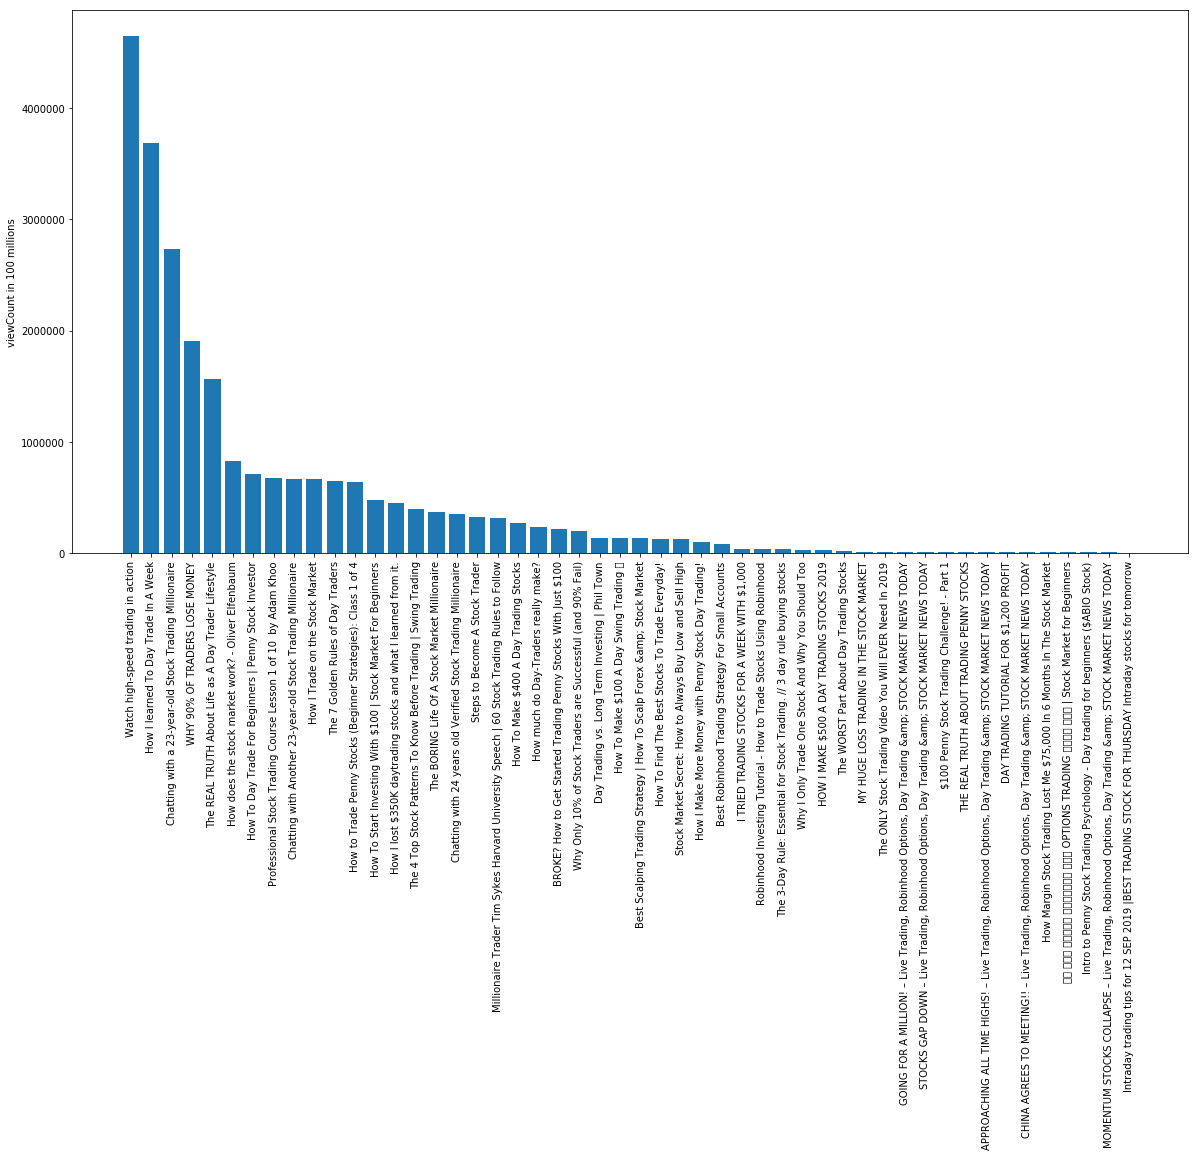

In [ ]:
stock_market = Outcome.copy()
stock_market = stock_market.sort_values(ascending=False,by='No_of_Views')
plt.figure(figsize=(20,10))
plt.bar(range(stock_market.shape[0]),stock_market['No_of_Views'])
plt.xticks(range(stock_market.shape[0]),stock_market['Video_Title'],rotation=90)
plt.ylabel('viewCount in 100 millions')
plt.show()

#TOP 10 Videos list 

https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

In [ ]:
stock_market[:10]

,Query,Tags,Channel_Name,Channel_Id,Video ID,Video_Title,Publish_Date&Time,Video_Description,No_of_Views,Category_Id,No_of_Comments,Comment ID,Comments,No_of_Replies,No_of_Likes,No_of_Dislikes
1539,Stock and Trading,"[CNNMoney, News, citadel, trading, stocks, NYS...",CNN Business,UCe-4xQosMQGkIA8mT4sR98Q,2u007Msq1qo,Watch high-speed trading in action,2013-07-05T20:16:46.000Z,"Citadel Group, a high-frequency trading firm l...",4646767,25,1976,Ugifv4GpzvlnCXgCoAEC,This much money and yet they cant make a HD vi...,53,2879,1655
285,Stock and Trading,"[garen phillips, day trade, stock market, Thin...",Garen Phillips,UCSupFapDqdOT-nxuvnOLSgw,GTtKLeDTCHo,How I learned To Day Trade In A Week,2017-06-27T18:28:02.000Z,"http://garenphillips.com/ ""Market Mind Games"" ...",3686548,26,4879,UgjWwBXWSJovEngCoAEC,Hey bud a member in our group shouted you out ...,102,3136,3723
485,Stock and Trading,"[Stock trading, stock market, stocks, money, m...",LAHWF,UCQlVOYJyQp64rA12ac0mv6g,4zhco2PA-TM,Chatting with a 23-year-old Stock Trading Mill...,2018-08-27T22:23:45.000Z,Umar's insta ▷ https://www.instagram.com/umara...,2727185,22,6136,Ugx25TVvEujd2A9WnZ14AaABAg,To answer some of the questions people have:\n...,475,10310,4351
3526,Stock and Trading,"[stocks, options, nasdaq, finance, market, S&P...",Sky View Trading,UCQU2q2zY1oejRRzK66fIAzA,j5PYredaIHo,WHY 90% OF TRADERS LOSE MONEY,2015-05-05T16:12:06.000Z,Sky View Trading https://skyviewtrading.com/ 3...,1904553,27,1881,UghuSKAUg62uyHgCoAEC,"""Be patient with your loses"" yea buy counter t...",19,291,2570
2585,Stock and Trading,"[how to day trade, who is cameron fous, what i...",Cameron Fous,UCwGflGmzevf4fcm-z8E-twA,1CizTHIM7BQ,The REAL TRUTH About Life as A Day Trader Life...,2017-11-02T15:22:41.000Z,Want to learn how I made $70k in a month as a ...,1563208,22,1946,UgygBYzzWLNwwa0cH914AaABAg,"Learn how i made $70,000 in 1 month with this ...",53,102,5477
585,Stock and Trading,"[TED, TED-Ed, TED Ed, Teded, Ted Education, Ol...",TED-Ed,UCsooa4yRKGN_zEE8iknghZA,p7HKvqRI_Bo,How does the stock market work? - Oliver Elfen...,2019-04-29T15:01:41.000Z,"Download a free audiobook version of ""The Rich...",826979,27,855,Ugy6cnjIoNBjPkCxhA94AaABAg,Interested in pursuing your own financial goal...,15,214,434
2039,Stock and Trading,"[tanner, fox, penny, stock, for, beginners, ro...",Ricky Gutierrez,UCtlAFoYl2aWb6pMiHCctQHA,cRMp_vHTwEU,How To Day Trade For Beginners | Penny Stock I...,2017-05-06T17:50:26.000Z,1. Course: https://learnplanprofit.net/lesson-...,715802,27,711,UgxRP659SDLJUJyLclZ4AaABAg,This looks much different than the GTA 5 stock...,1,71,399
166,Stock and Trading,"[adam khoo, adamkhoowealth1, wealthacademySG, ...",Adam Khoo,UCK-aOjEvZNJl3HINja0gAiQ,slBxM4J3BEA,Professional Stock Trading Course Lesson 1 of ...,2018-02-28T04:54:37.000Z,If you want to learn how to trade stocks profi...,671952,22,636,UgyPM9bdN4QI2ykMFfh4AaABAg,"Finally, someone making video that actually te...",7,218,244
2141,Stock and Trading,"[stock trading, stock market, stocks, money, r...",LAHWF,UCQlVOYJyQp64rA12ac0mv6g,PbbsNsdwjLM,Chatting with Another 23-year-old Stock Tradin...,2018-11-20T20:26:12.000Z,Ricky Gutierrez Channel ▷ https://bit.ly/2HOgE...,663968,22,3327,UgyBFqfL9TDUYVQccVZ4AaABAg,Andrew and this guy are on two different speeds,58,2331,1234
1639,Stock and Trading,"[travel, traveling, travelling, traveler, trav...",Travellight,UCZ4hZoV-OOUo14Qm7aQE6zA,vk8v3hOT5iY,How I Trade on the Stock Market,2016-11-12T13:55:09.000Z,Read description for answers to frequently ask...,662872,22,3189,Ugjz9Yiou_8suHgCoAEC,I hadn't checked the comments on this video in...,197,534,2248


#Comments Analysis - Study of the human's Attitude Towards these Videos

In [ ]:
comments =[]
for i in range(len(df)):
  comments+=df['Comments'][i].split()

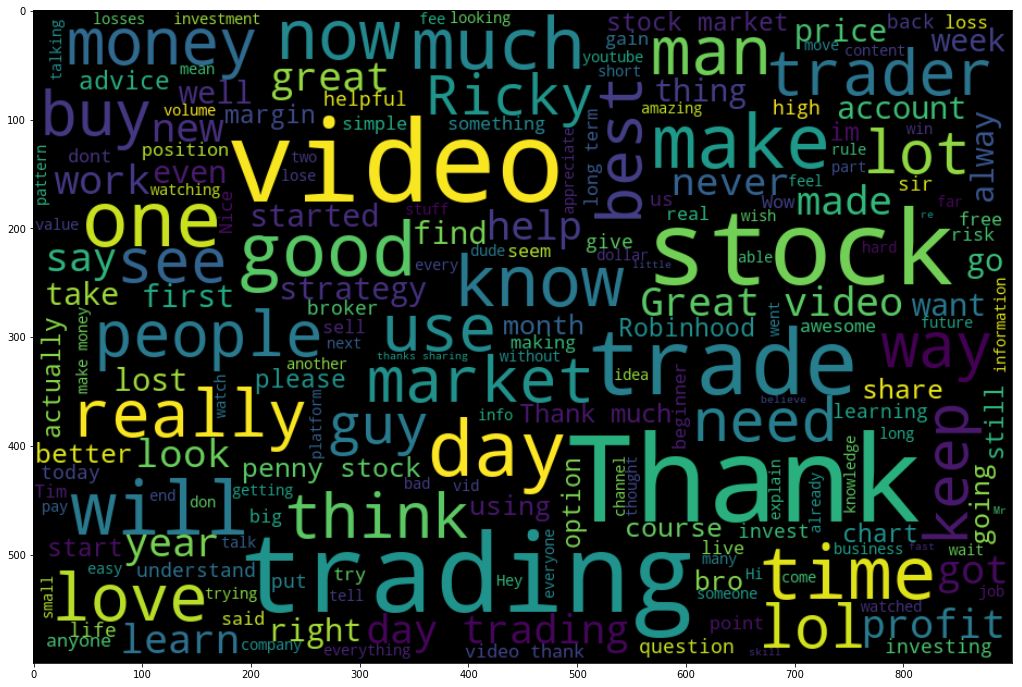

In [ ]:
all_words = ' '.join([comment for comment in comments])
from wordcloud import WordCloud
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(20, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('on')
plt.show()

#It is not complete yet , lots of discussion remaining .....!Priyansh Gupta!
#i will use NLP to get the sentiment of the people towards the vedios